# **Imports**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


# **Data Preparation**

In [2]:
class Preprocessing:
	
	def __init__(self):
		self.data = 'tweets.csv'
		self.max_len = 10
		self.max_words = 100
		self.test_size = 0.5
		
	def load_data(self):
		df = pd.read_csv(self.data)
		df.drop(['id','keyword','location'], axis=1, inplace=True)
		
		X = df['text'].values
		Y = df['target'].values
		
		self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=self.test_size)
		
	def prepare_tokens(self):
		self.tokens = Tokenizer(num_words=self.max_words)
		self.tokens.fit_on_texts(self.x_train)

	def sequence_to_token(self, x):
		sequences = self.tokens.texts_to_sequences(x)
		return sequence.pad_sequences(sequences, maxlen=self.max_len)

# **Model Creation**

In [3]:
class TweetClassifier(nn.ModuleList):

	def __init__(self):
		super(TweetClassifier, self).__init__()
		
		# Hyperparameters
		self.batch_size = 64
		self.hidden_dim = 128
		self.LSTM_layers = 2
		self.input_size = 100
		
		self.dropout = nn.Dropout(0.5)
		self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
		self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
		self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim*2)
		self.fc2 = nn.Linear(self.hidden_dim*2, 1)
		
	def forward(self, x):
		
		# Hidden and cell state definion
		h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		
		# Initialization fo hidden and cell states
		torch.nn.init.xavier_normal_(h)
		torch.nn.init.xavier_normal_(c)

		# Each sequence "x" is passed through an embedding layer
		out = self.embedding(x)
		# Feed LSTMs
		out, (hidden, cell) = self.lstm(out, (h,c))
		out = self.dropout(out)
		# The last hidden state is taken
		out = torch.relu_(self.fc1(out[:,-1,:]))
		out = self.dropout(out)
		out = torch.sigmoid(self.fc2(out))

		return out

# **Dataset Handler**

In [4]:
class DatasetMaper(Dataset):
	'''
	Handles batches of dataset
	'''
  
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

# **Train & Evaluate**

In [5]:
class Execute:
	'''
	Class for execution. Initializes the preprocessing as well as the 
	Tweet Classifier model
	'''

	def __init__(self):
		self.__init_data__()
		
		self.batch_size = 64
		self.model = TweetClassifier()
		
	def __init_data__(self):
		'''
		Initialize preprocessing from raw dataset to dataset split into training and testing
		Training and test datasets are index strings that refer to tokens
		'''
		self.preprocessing = Preprocessing()
		self.preprocessing.load_data()
		self.preprocessing.prepare_tokens()

		raw_x_train = self.preprocessing.x_train
		raw_x_test = self.preprocessing.x_test
		
		self.y_train = self.preprocessing.y_train
		self.y_test = self.preprocessing.y_test

		self.x_train = self.preprocessing.sequence_to_token(raw_x_train)
		self.x_test = self.preprocessing.sequence_to_token(raw_x_test)
		
	def train(self):
      
		training_set = DatasetMaper(self.x_train, self.y_train)
		test_set = DatasetMaper(self.x_test, self.y_test)

		self.loader_training = DataLoader(training_set, batch_size=self.batch_size)
		self.loader_test = DataLoader(test_set)

		optimizer = optim.RMSprop(self.model.parameters(), lr=0.01)
    
		losses = []
		train_acc = []
		test_acc = []
    
		for epoch in range(15):
			predictions = []

			self.model.train()
			
			for x_batch, y_batch in self.loader_training:
				x = x_batch.type(torch.LongTensor)
				y = y_batch.type(torch.FloatTensor)
				y = y.unsqueeze(1)

				y_pred = self.model(x)

				loss = F.binary_cross_entropy(y_pred, y)
				optimizer.zero_grad()
				
				loss.backward()
				
				optimizer.step()
				
				predictions += list(y_pred.squeeze().detach().numpy())
			
			test_predictions = self.evaluation()
			
			train_accuary = self.calculate_accuray(self.y_train, predictions)
			test_accuracy = self.calculate_accuray(self.y_test, test_predictions)
			
			losses.append(loss.item())
			train_acc.append(train_accuary)
			test_acc.append(test_accuracy)
			   
			print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f" % (epoch+1, loss.item(), train_accuary, test_accuracy))
		
		return losses, train_acc, test_acc

	def evaluation(self):

		predictions = []
		self.model.eval()
		with torch.no_grad():
			for x_batch, y_batch in self.loader_test:
				x = x_batch.type(torch.LongTensor)
				y = y_batch.type(torch.FloatTensor)
				
				y_pred = self.model(x)
				predictions += list(y_pred.detach().numpy())
				
		return predictions
			
	@staticmethod
	def calculate_accuray(grand_truth, predictions):
		true_positives = 0
		true_negatives = 0
		
		for true, pred in zip(grand_truth, predictions):
			if (pred > 0.5) and (true == 1):
				true_positives += 1
			elif (pred < 0.5) and (true == 0):
				true_negatives += 1
			else:
				pass
				
		return (true_positives+true_negatives) / len(grand_truth)

# **Training The Model**

In [6]:
execute = Execute()
losses, train_acc, test_acc = execute.train()

Epoch: 1, loss: 43.33333, Train accuracy: 0.42722, Test accuracy: 0.43551
Epoch: 2, loss: 43.33333, Train accuracy: 0.42380, Test accuracy: 0.43551
Epoch: 3, loss: 43.33333, Train accuracy: 0.42380, Test accuracy: 0.43551
Epoch: 4, loss: 0.74727, Train accuracy: 0.48660, Test accuracy: 0.61860
Epoch: 5, loss: 0.72225, Train accuracy: 0.59800, Test accuracy: 0.60152
Epoch: 6, loss: 0.68630, Train accuracy: 0.61876, Test accuracy: 0.58156
Epoch: 7, loss: 0.77597, Train accuracy: 0.63137, Test accuracy: 0.58524
Epoch: 8, loss: 0.61018, Train accuracy: 0.66054, Test accuracy: 0.68348
Epoch: 9, loss: 0.55385, Train accuracy: 0.68760, Test accuracy: 0.68532
Epoch: 10, loss: 0.57576, Train accuracy: 0.70862, Test accuracy: 0.68794
Epoch: 11, loss: 0.45093, Train accuracy: 0.71650, Test accuracy: 0.68164
Epoch: 12, loss: 0.41889, Train accuracy: 0.73095, Test accuracy: 0.68190
Epoch: 13, loss: 0.44883, Train accuracy: 0.75197, Test accuracy: 0.69451
Epoch: 14, loss: 0.30705, Train accuracy: 0.

# **Plots**

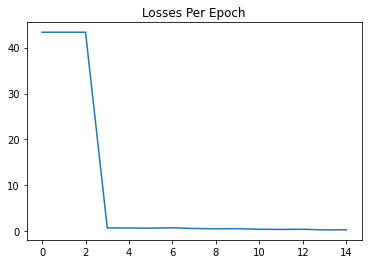

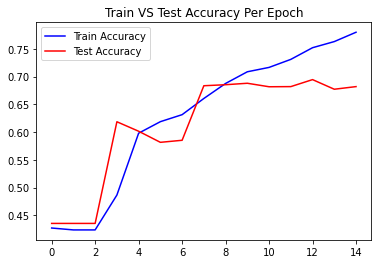

In [7]:
plt.plot(losses)
plt.title("Losses Per Epoch")
plt.show()

plt.plot(train_acc,color='blue',label='Train Accuracy')
plt.plot(test_acc, color='red',label='Test Accuracy')
plt.title("Train VS Test Accuracy Per Epoch")
plt.legend()
plt.show()